In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LinearRegression, LogisticRegression
from imblearn.over_sampling import SMOTE

from scipy.stats import chi2_contingency
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer

from tqdm import tqdm
import warnings
from pprint import pprint

In [103]:
data = pd.read_csv("./data/augmented_data.csv")

In [104]:
data.nunique()

period                     5
minute                   139
possession               290
duration               77925
season_id                 41
match_id                3312
timestamp              82726
team                     288
play_pattern               9
position                  25
location_x               635
location_x_distance      635
location_y               701
location_y_distance      471
technique                  7
body_part                  4
type                       5
is_penalty                 2
first_time                 2
open_goal                  2
one_on_one                 2
aerial_won                 2
follows_dribble            2
under_pressure             2
pass_duration          11897
pass_angle             10504
pass_type                  8
pass_height                4
pass_length             9918
num_passes                13
defenders_3m_radius       10
defenders_triangle        13
shooting_range         43794
best_distance          30176
goalkeeper_x  

In [105]:
# Use mutual_info classification to check which features yield the most information about the target variable
data_copy = data.copy()
X_copy = data_copy.drop(["statsbomb_xg", "is_goal", "end_location_x", "end_location_y", "location_x", "location_y", "play_pattern", "technique", "position", "body_part", "type", "pass_type", "pass_height", "season_id", "match_id", "timestamp", "team"], axis=1)
mutual_info = mutual_info_classif(X_copy, data["is_goal"])
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_copy.columns
mutual_info.sort_values(ascending=False)

distance_to_goalie     0.059008
shooting_range         0.052146
best_distance          0.050183
defenders_triangle     0.038475
location_x_distance    0.035254
goalkeeper_x           0.027204
defenders_3m_radius    0.023645
duration               0.021763
location_y_distance    0.021484
goalkeeper_y           0.020907
is_penalty             0.016054
shot_angle             0.013746
open_goal              0.011004
pass_length            0.009711
pass_duration          0.009310
period                 0.008618
num_passes             0.007360
good_foot              0.005918
first_time             0.005091
minute                 0.004762
one_on_one             0.004472
pass_angle             0.003400
under_pressure         0.003361
was_leading            0.003215
aerial_won             0.001856
game_state             0.001588
possession             0.001563
xg_so_far              0.001536
follows_dribble        0.000000
shots_so_far           0.000000
dtype: float64

In [106]:
data = data.dropna()
data.replace([np.inf, -np.inf], 0, inplace=True)

In [107]:
data.nunique()

period                     5
minute                   139
possession               290
duration               77925
season_id                 41
match_id                3312
timestamp              82726
team                     288
play_pattern               9
position                  25
location_x               635
location_x_distance      635
location_y               701
location_y_distance      471
technique                  7
body_part                  4
type                       5
is_penalty                 2
first_time                 2
open_goal                  2
one_on_one                 2
aerial_won                 2
follows_dribble            2
under_pressure             2
pass_duration          11897
pass_angle             10504
pass_type                  8
pass_height                4
pass_length             9918
num_passes                13
defenders_3m_radius       10
defenders_triangle        13
shooting_range         43794
best_distance          30176
goalkeeper_x  

In [108]:
X = data.drop(["statsbomb_xg", "is_goal", "end_location_x", "end_location_y", "location_x", "location_y", "play_pattern", "technique", "position", "body_part", "type", "pass_type", "pass_height", "season_id", "match_id", "timestamp", "team"], axis=1)
y1 = data["statsbomb_xg"]
y2 = data["is_goal"]

In [109]:
X, y2 = SMOTE(sampling_strategy=0.36).fit_resample(X, y2)

In [110]:
chi = []
for column in ["is_penalty", "first_time", "open_goal", "one_on_one", "under_pressure", "defenders_3m_radius", "defenders_triangle", "good_foot"]:
    contingency_table = pd.crosstab(X[column], y2)
    chi2, p, dof, _ = chi2_contingency(contingency_table)
    chi.append((column, chi2, p, dof))

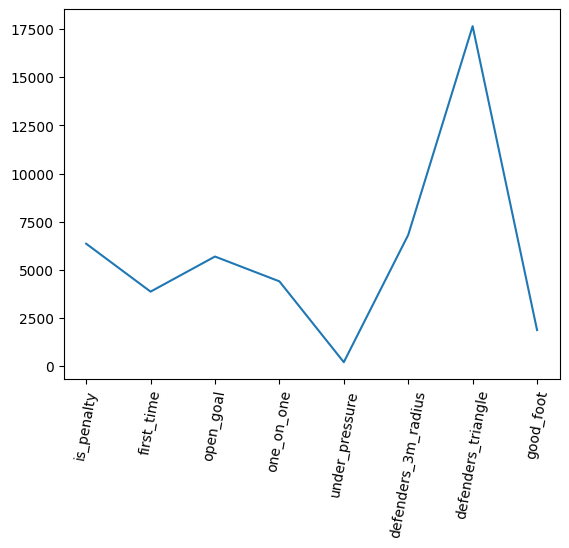

In [111]:
ax = pd.Series([x[1] for x in chi]).plot(xticks=pd.Series([x[0] for x in chi]).index, rot=80)
_ = ax.set_xticklabels(pd.Series([x[0] for x in chi]))

In [112]:
# Is the number of defenders in the triangle between the shooter and the goal significant to the likelihood of scoring?
contingency_table = pd.crosstab(X['defenders_triangle'], y2)
chi2, p, dof, _ = chi2_contingency(contingency_table)

# Output results
print("Chi-squared statistic:", chi2)
print("P-value:", p)
print("Degrees of freedom:", dof)

Chi-squared statistic: 17649.92127704103
P-value: 0.0
Degrees of freedom: 12


In [113]:
# Is the shooter being on their favoured side significant to the likelihood of scoring?
contingency_table = pd.crosstab(X['good_foot'], y2)
chi2, p, dof, _ = chi2_contingency(contingency_table)

# Output results
print("Chi-squared statistic:", chi2)
print("P-value:", p)
print("Degrees of freedom:", dof)

Chi-squared statistic: 1874.4491425939414
P-value: 0.0
Degrees of freedom: 1


In [114]:
# Is the shooter being on their favoured side significant to the likelihood of scoring?
contingency_table = pd.crosstab(X['was_leading'], y2)
chi2, p, dof, _ = chi2_contingency(contingency_table)

# Output results
print("Chi-squared statistic:", chi2)
print("P-value:", p)
print("Degrees of freedom:", dof)

Chi-squared statistic: 3377.091787585823
P-value: 0.0
Degrees of freedom: 2


In [115]:
model = LinearRegression()
model.fit(pd.DataFrame(X_copy['distance_to_goalie']), y1)

# Print coefficients
print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)

Intercept: 0.08661084496116633
Coefficients: [0.00110205]


In [147]:
results1 = smf.ols('statsbomb_xg ~ distance_to_goalie + best_distance + location_x_distance', data=data).fit()
results2 = smf.ols('statsbomb_xg ~ shooting_range + best_distance', data=data).fit()
results3 = smf.ols('statsbomb_xg ~ defenders_triangle + defenders_3m_radius', data=data).fit()
results4 = smf.ols('statsbomb_xg ~ location_y_distance + good_foot', data=data).fit()
results5 = smf.ols('statsbomb_xg ~ location_x + location_y + goalkeeper_x + goalkeeper_y', data=data).fit()
results6 = smf.ols('statsbomb_xg ~ distance_to_goalie + best_distance + defenders_triangle + under_pressure + shooting_range', data=data).fit()

In [148]:
stargazer_tab = Stargazer([results1, results2, results3, results4, results5, results6])
stargazer_tab

In [142]:
results1 = smf.ols('location_x_distance ~ was_leading', data=data).fit()
results2 = smf.ols('best_distance ~ was_leading', data=data).fit()

In [143]:
stargazer_tab = Stargazer([results1, results2])
stargazer_tab